In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform, RandomNormal
import random, os, pickle, copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
savedir = os.path.join('./save/find_smallest_network_cifar5')

Using TensorFlow backend.


In [3]:
def map_to_range(arr):
    narr = np.zeros_like(arr, dtype=np.int64)
    vals = np.unique(arr)
    for i, v in enumerate(vals):
        mask = (arr == v)
        narr[mask] = i
    return narr

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
input_shape = (32, 32, 3)
num_classes = 5

y_test = y_test.astype(np.int64).squeeze()
y_train = y_train.astype(np.int64).squeeze()

# labels found to give roughly equal classification performance
set_1_test_mask = np.isin(y_test, np.array([0, 3, 4, 6, 7])).squeeze()
set_1_train_mask = np.isin(y_train, np.array([0, 3, 4, 6, 7])).squeeze()

set_2_test_mask = np.isin(y_test, np.array([1, 2, 5, 8, 9])).squeeze()
set_2_train_mask = np.isin(y_train, np.array([1, 2, 5, 8, 9])).squeeze()

set_1_train_labels = y_train[set_1_train_mask]
x_train_1 = x_train[set_1_train_mask]
set_1_test_labels = y_test[set_1_test_mask]
x_test_1 = x_test[set_1_test_mask]
set_2_train_labels = y_train[set_2_train_mask]
x_train_2 = x_train[set_2_train_mask]
set_2_test_labels = y_test[set_2_test_mask]
x_test_2 = x_test[set_2_test_mask]

y_train_1 = keras.utils.to_categorical(map_to_range(set_1_train_labels), num_classes)
y_train_2 = keras.utils.to_categorical(map_to_range(set_2_train_labels), num_classes)
y_test_1 = keras.utils.to_categorical(map_to_range(set_1_test_labels), num_classes)
y_test_2 = keras.utils.to_categorical(map_to_range(set_2_test_labels), num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
datagen1 = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen1.fit(x_train_1)

datagen2= ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen2.fit(x_train_2)

In [6]:
def set_up_model(lr=1e-3, nfilters=[2, 4, 8], ndense=128):
    keras.backend.clear_session()
    inputs = Input(shape=input_shape)
    x = Conv2D(nfilters[0], kernel_size=(7,7), strides=(1, 1), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(nfilters[1], kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(nfilters[2], kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(ndense, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=['accuracy'])
    return model

In [50]:
epochs = 100
batch_size = 128

n_dense = [32, 64, 128]
constant_filters = [160, 160, 160]
exp_filters = []
i = 0
for d in n_dense:
    for f in constant_filters:        
        model = set_up_model(nfilters=[f, f, f], ndense=d)
        history = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                      epochs=epochs,
                                      verbose=2,
                                      validation_data=(x_test_1, y_test_1),
                                      )
        sp = os.path.join(savedir, 'history_%d_dense_%d_filters.pkl'%(d, f))
        print('Saving to :', sp)
        with open(sp, 'wb') as f:
            pickle.dump(history.history, f)

    for f in exp_filters:
        model = set_up_model(nfilters=[2**(f), 2**(f+1), 2**(f+2)], ndense=d)
        history = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                      epochs=epochs,
                                      verbose=2,
                                      validation_data=(x_test_1, y_test_1),
                                      )
        sp = os.path.join(savedir, 'history_%d_dense_exp_%d_filters.pkl'%(d, f))
        print('Saving to :', sp)
        with open(sp, 'wb') as f:
            pickle.dump(history.history, f)

Epoch 1/100
 - 24s - loss: 1.4383 - acc: 0.3711 - val_loss: 1.2383 - val_acc: 0.5114
Epoch 2/100
 - 29s - loss: 1.2633 - acc: 0.4866 - val_loss: 1.1176 - val_acc: 0.5632
Epoch 3/100
 - 28s - loss: 1.1750 - acc: 0.5377 - val_loss: 1.0145 - val_acc: 0.6084
Epoch 4/100
 - 28s - loss: 1.1393 - acc: 0.5511 - val_loss: 1.0140 - val_acc: 0.6052
Epoch 5/100
 - 27s - loss: 1.1069 - acc: 0.5639 - val_loss: 0.9637 - val_acc: 0.6372
Epoch 6/100
 - 29s - loss: 1.0843 - acc: 0.5793 - val_loss: 0.9259 - val_acc: 0.6476
Epoch 7/100
 - 28s - loss: 1.0561 - acc: 0.5894 - val_loss: 0.9150 - val_acc: 0.6492
Epoch 8/100
 - 28s - loss: 1.0296 - acc: 0.6007 - val_loss: 0.8754 - val_acc: 0.6696
Epoch 9/100
 - 29s - loss: 1.0051 - acc: 0.6131 - val_loss: 0.8378 - val_acc: 0.6818
Epoch 10/100
 - 31s - loss: 0.9835 - acc: 0.6237 - val_loss: 0.9131 - val_acc: 0.6566
Epoch 11/100
 - 29s - loss: 0.9717 - acc: 0.6287 - val_loss: 0.8363 - val_acc: 0.6726
Epoch 12/100
 - 28s - loss: 0.9587 - acc: 0.6329 - val_loss: 0.

Epoch 97/100
 - 27s - loss: 0.7161 - acc: 0.7364 - val_loss: 0.5888 - val_acc: 0.7824
Epoch 98/100
 - 27s - loss: 0.7130 - acc: 0.7383 - val_loss: 0.5550 - val_acc: 0.7960
Epoch 99/100
 - 27s - loss: 0.7215 - acc: 0.7350 - val_loss: 0.5979 - val_acc: 0.7806
Epoch 100/100
 - 28s - loss: 0.7223 - acc: 0.7377 - val_loss: 0.5887 - val_acc: 0.7822
Saving to : ./save/find_smallest_network_cifar5/history_32_dense_16_filters.pkl
Epoch 1/100
 - 34s - loss: 1.4285 - acc: 0.3767 - val_loss: 1.2122 - val_acc: 0.5276
Epoch 2/100


KeyboardInterrupt: 

In [7]:
n_dense = [32, 64, 128]
constant_filters = [2, 4, 8, 16, 32, 64, 160]
exp_filters = [1, 2, 3, 4, 5, 6]

constant_histories = []
exp_histories = []

for i, nd in enumerate(n_dense):
    for j, nf in enumerate(constant_filters):
        with open(os.path.join(savedir, 'history_%d_dense_%d_filters.pkl'%(nd, nf)), 'rb') as f:
            constant_histories.append(((nd, nf), pickle.load(f)))
    for j, nf in enumerate(exp_filters):
        with open(os.path.join(savedir, 'history_%d_dense_exp_%d_filters.pkl'%(nd, nf)), 'rb') as f:
            exp_histories.append(((nd, nf), pickle.load(f)))
            

In [8]:
len(exp_histories)

18

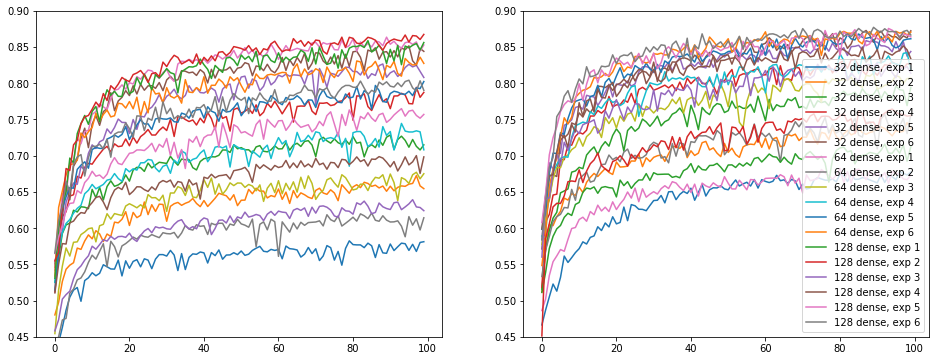

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches([16, 6])
for i in range(len(exp_histories)):
    ax[0].plot(constant_histories[i][1]['val_acc'], label='%d dense, %d filters'%constant_histories[i][0])
    ax[1].plot(exp_histories[i][1]['val_acc'], label='%d dense, exp %d'%exp_histories[i][0])
ax[0].set_ylim(0.45, 0.9)
ax[1].set_ylim(0.45, 0.9)

plt.legend()
plt.show()

In [10]:
def network_parameters(n_filters, n_dense):
    nchannels = [3] + copy.deepcopy(n_filters)
    params_conv_layers = [7*7, 3*3, 3*3]
    conv_params = [n_filters[i]*params_conv_layers[i]*nchannels[i] + n_filters[i] for i in range(3)]
    dense_params = n_filters[-1]*4*4*n_dense + n_dense + n_dense*5 + 5
    return sum(conv_params) + dense_params

In [11]:
for h in constant_histories:
    print(h[0])

(32, 2)
(32, 4)
(32, 8)
(32, 16)
(32, 32)
(32, 64)
(32, 160)
(64, 2)
(64, 4)
(64, 8)
(64, 16)
(64, 32)
(64, 64)
(64, 160)
(128, 2)
(128, 4)
(128, 8)
(128, 16)
(128, 32)
(128, 64)
(128, 160)


In [12]:
const_params = []
for h in constant_histories:
    const_params.append(network_parameters([h[0][1] for _ in range(3)], h[0][0]))
exp_params = []
for h in exp_histories:
    exp_params.append(network_parameters([2**(h[0][1]+i) for i in range(3)], h[0][0]))

In [13]:
best_acc_const = [max(h[1]['val_acc']) for h in constant_histories]
best_acc_exp = [max(h[1]['val_acc']) for h in exp_histories]

In [14]:
from scipy.optimize import curve_fit

In [15]:
def log_func(x, a, b):
    return a*np.log(b*x)
def linear_func(x, a, b):
    return a*x + b
def inverse_exp_func(x, a, b):
    return (a - np.exp(-b/x))

In [16]:
use_func = inverse_exp_func

In [17]:
x = np.array(const_params + exp_params)

In [18]:
y = np.array(best_acc_const + best_acc_exp)

In [19]:
x2, y2 = np.array(const_params), np.array(best_acc_const)
x3, y3 = np.array(exp_params), np.array(best_acc_exp)

In [20]:
popt, pcov = curve_fit(use_func, x, y)
popt2, pcov2 = curve_fit(use_func, x2, y2)
popt3, pcov3 = curve_fit(use_func, x3, y3)

In [21]:
xplot = np.linspace(700, 900000, 1000)

(0, 1000000)

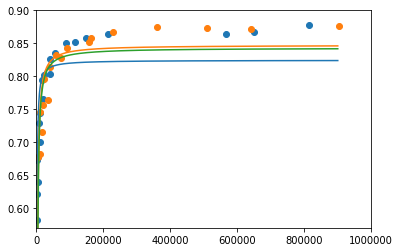

In [46]:
plt.plot(xplot, use_func(xplot, *popt2))
plt.plot(xplot, use_func(xplot, *popt3))
plt.plot(xplot, use_func(xplot, *popt))
plt.scatter(x2, y2)
plt.scatter(x3, y3)
plt.ylim(0.57, 0.9)
plt.xlim(0, 1000000)

(0, 1000000)

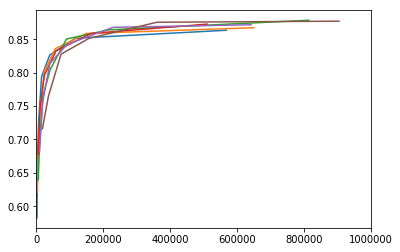

In [23]:
for i in range(3):
    plt.plot(x2[i*7:(i+1)*7], y2[i*7:(i+1)*7])
for i in range(3):
    plt.plot(x3[i*6:(i+1)*6], y3[i*6:(i+1)*6])
plt.xlim(0, 1000000)

In [24]:
accs_const = []
params_const = []
accs_exp = []
params_exp = []
for i in range(3):
    accs_const.append(best_acc_const[i*7:(i+1)*7])
    params_const.append(const_params[i*7:(i+1)*7])
for i in range(3):
    accs_exp.append(best_acc_exp[i*6:(i+1)*6])
    params_exp.append(exp_params[i*6:(i+1)*6])

In [25]:
exp_popts = []
const_popts = []
for i, acc in enumerate(accs_exp):
    popt, pcov = curve_fit(use_func, params_exp[i][:5], acc[:5])
    exp_popts.append(popt)
for i, acc in enumerate(accs_const):
    popt, pcov = curve_fit(use_func, params_const[i][:6], acc[:6])
    const_popts.append(popt)

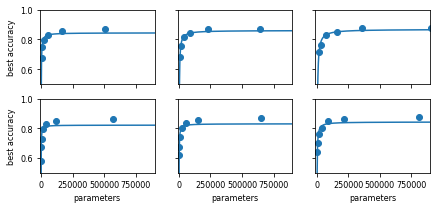

In [39]:
xplot = np.linspace(700, 900000, 1000)
fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=[7,3])
for i in range(3):
    ax.flat[i].plot(xplot, use_func(xplot, *exp_popts[i]))
    ax.flat[i].scatter(params_exp[i], accs_exp[i])
for i in range(3):
    ax.flat[i+3].plot(xplot, use_func(xplot,*const_popts[i]))
    ax.flat[i+3].scatter(params_const[i], accs_const[i])

plt.xlim(-10000, 900000)
plt.ylim(0.5, 1)
for a in ax[:,0]:
    a.set_ylabel('best accuracy', fontdict={'fontsize': 8.})
    a.tick_params(labelsize=8)
for a in ax[1,:]:
    a.set_xlabel('parameters', fontdict={'fontsize': 8.})
    a.tick_params(labelsize=8)

(0.6, 1)

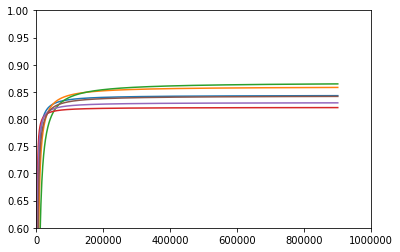

In [32]:
for p in exp_popts + const_popts:
    plt.plot(xplot,  use_func(xplot, *p))
plt.xlim(0, 1000000)
plt.ylim(0.6, 1)